## Question 3: Vowel Classification System



#### This notebook implements a system to classify five different vowel sounds (/a/, /e/, /i/, /o/, /u/) using traditional speech processing techniques, including formant extraction and classification.

#### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import os
import pandas as pd
from scipy.signal import lfilter
from scipy.linalg import toeplitz
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from scipy.signal import find_peaks
import warnings
warnings.filterwarnings('ignore')

#### Constants

In [2]:
SAMPLE_RATE = 16000  # Sample rate for analysis
FRAME_SIZE = 512     # Frame size for analysis
HOP_LENGTH = 256     # Hop length for analysis
N_FORMANTS = 3       # Number of formants to extract (F1, F2, F3)
LPC_ORDER = 12       # Order of LPC analysis
OUTPUT_DIR = 'question_3'  # Output directory for all files

In [3]:
# Create output directory
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

#### Dataset

In [4]:
def create_vowel_dataset(base_dir='vowel_samples'):
    """
    Create or use an existing dataset of vowel sounds
    """
    vowels = ['a', 'e', 'i', 'o', 'u']
    dataset = []
    
    # Categories in the dataset
    categories = ['Female', 'Male']
    
    # Collect file paths and labels
    for category in categories:
        category_dir = os.path.join(base_dir, category)
        if os.path.exists(category_dir):
            for vowel in vowels:
                vowel_dir = os.path.join(category_dir, vowel)
                if os.path.exists(vowel_dir):
                    for file in os.listdir(vowel_dir):
                        if file.endswith('.wav'):
                            file_path = os.path.join(vowel_dir, file)
                            dataset.append((file_path, vowel, category))
    
    print(f"Found {len(dataset)} vowel samples across {len(categories)} categories.")
    return dataset


#### Audio Pre-processing

In [5]:
def load_audio(file_path):
    """
    Load an audio file using librosa
    """
    try:
        y, sr = librosa.load(file_path, sr=SAMPLE_RATE)
        return y, sr
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None, None

def preprocess_audio(y, sr):
    """
    Preprocess audio signal for analysis
    """
    if y is None:
        return None
    
    # Ensure the audio is not empty
    if len(y) == 0:
        print("Warning: Empty audio signal")
        return None
    
    # Trim silence
    y_trimmed, _ = librosa.effects.trim(y, top_db=20)
    
    # Normalize
    y_normalized = librosa.util.normalize(y_trimmed)
    
    return y_normalized

def frame_audio(y, frame_size=FRAME_SIZE, hop_length=HOP_LENGTH):
    """
    Divide audio signal into frames
    """
    if y is None:
        return None
    
    # Apply Hamming window to each frame
    frames = librosa.util.frame(y, frame_length=frame_size, hop_length=hop_length)
    windows = np.hamming(frame_size).reshape(-1, 1)
    windowed_frames = frames * windows
    
    return windowed_frames

#### Compute LPC

In [22]:
def compute_lpc(frame, order=LPC_ORDER):
    """
    Compute Linear Predictive Coding coefficients
    """
    # Compute autocorrelation
    r = np.correlate(frame, frame, mode='full')
    r = r[len(frame)-1:len(frame)+order]
    
    # Create Toeplitz matrix
    R = toeplitz(r[:-1])
    
    # Solve for LPC coefficients
    try:
        a = np.linalg.solve(R, r[1:])
        return np.concatenate(([1.0], -a))
    except np.linalg.LinAlgError:
        # If matrix is singular, return zeros
        return np.zeros(order + 1)

#### Formant Estimation

In [23]:
def estimate_formants(lpc_coeffs, sr=SAMPLE_RATE):
    """
    Estimate formant frequencies from LPC coefficients
    """
    # Find roots of the LPC polynomial
    roots = np.roots(lpc_coeffs)
    
    # Keep only roots with positive imaginary part and inside the unit circle
    roots = roots[np.imag(roots) > 0]
    roots = roots[np.abs(roots) < 0.99]
    
    # Convert to angles and then to frequencies
    angles = np.arctan2(np.imag(roots), np.real(roots))
    freqs = angles * (sr / (2 * np.pi))
    
    # Sort by frequency
    freqs = np.sort(freqs)
    
    # Return first N_FORMANTS formants or pad with zeros if not enough
    if len(freqs) >= N_FORMANTS:
        return freqs[:N_FORMANTS]
    else:
        return np.pad(freqs, (0, N_FORMANTS - len(freqs)), 'constant')

#### Fundamental Frequency (Pitch) Extraction

In [7]:
def extract_fundamental_frequency(y, sr=SAMPLE_RATE, frame_size=FRAME_SIZE, hop_length=HOP_LENGTH):
    """
    Extract fundamental frequency (F0) using autocorrelation
    """
    # Use librosa's implementation of PYIN for F0 estimation
    f0, voiced_flag, voiced_probs = librosa.pyin(y, 
                                               fmin=librosa.note_to_hz('C2'), 
                                               fmax=librosa.note_to_hz('C7'),
                                               sr=sr,
                                               frame_length=frame_size,
                                               hop_length=hop_length)
    
    # Replace NaN values with 0
    f0 = np.nan_to_num(f0)
    
    return f0

#### Feature Extraction

In [8]:
def extract_features(file_path):
    """
    Extract formant and fundamental frequency features from an audio file
    """
    # Load and preprocess audio
    y, sr = load_audio(file_path)
    if y is None:
        return None
    
    y_preprocessed = preprocess_audio(y, sr)
    if y_preprocessed is None:
        return None
    
    # Frame the audio
    frames = frame_audio(y_preprocessed)
    if frames is None:
        return None
    
    # Extract formants for each frame
    formants = []
    for frame in frames.T:  # Transpose to iterate over frames
        lpc_coeffs = compute_lpc(frame)
        frame_formants = estimate_formants(lpc_coeffs, sr)
        formants.append(frame_formants)
    
    formants = np.array(formants)
    
    # Extract fundamental frequency
    f0 = extract_fundamental_frequency(y_preprocessed, sr)
    
    # Compute mean formant frequencies and F0
    mean_formants = np.nanmean(formants, axis=0)
    mean_f0 = np.nanmean(f0)
    
    # Compute standard deviation of formant frequencies and F0
    std_formants = np.nanstd(formants, axis=0)
    std_f0 = np.nanstd(f0)
    
    # Compute formant ratios (can be useful for classification)
    f1_f2_ratio = mean_formants[0] / mean_formants[1] if mean_formants[1] > 0 else 0
    f2_f3_ratio = mean_formants[1] / mean_formants[2] if mean_formants[2] > 0 else 0
    
    # Create feature dictionary
    features = {
        'F1_mean': mean_formants[0] if len(mean_formants) > 0 else 0,
        'F2_mean': mean_formants[1] if len(mean_formants) > 1 else 0,
        'F3_mean': mean_formants[2] if len(mean_formants) > 2 else 0,
        'F0_mean': mean_f0,
        'F1_std': std_formants[0] if len(std_formants) > 0 else 0,
        'F2_std': std_formants[1] if len(std_formants) > 1 else 0,
        'F3_std': std_formants[2] if len(std_formants) > 2 else 0,
        'F0_std': std_f0,
        'F1_F2_ratio': f1_f2_ratio,
        'F2_F3_ratio': f2_f3_ratio,
        'formants': formants,
        'f0': f0
    }
    
    return features


#### Formant Space Visualization

In [28]:
def visualize_formant_space(features_df, save_path=os.path.join(OUTPUT_DIR, 'formant_space.png')):
    """
    Visualize the vowel formant space using F1 and F2
    """
    plt.figure(figsize=(10, 8))
    
    # Plot F1-F2 space (inverted axes to match linguistic convention)
    vowels = features_df['vowel'].unique()
    colors = ['r', 'g', 'b', 'c', 'm']
    
    for i, vowel in enumerate(vowels):
        vowel_data = features_df[features_df['vowel'] == vowel]
        plt.scatter(vowel_data['F2_mean'], vowel_data['F1_mean'], 
                   c=colors[i % len(colors)], label=f'/{vowel}/', alpha=0.7)
    
    # Add labels for each point
    for i, row in features_df.iterrows():
        plt.text(row['F2_mean'], row['F1_mean'], row['vowel'], fontsize=8)
    
    # Invert axes to match linguistic convention (higher formant values at bottom-left)
    plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()
    
    plt.title('Vowel Formant Space (F1-F2)')
    plt.xlabel('F2 (Hz)')
    plt.ylabel('F1 (Hz)')
    plt.legend()
    plt.grid(True)
    
    # Add theoretical vowel positions as a reference
    theoretical_positions = {
        'a': (800, 1200),  # F1, F2 for /a/
        'e': (500, 1800),  # F1, F2 for /e/
        'i': (300, 2200),  # F1, F2 for /i/
        'o': (500, 900),   # F1, F2 for /o/
        'u': (300, 800)    # F1, F2 for /u/
    }
    
    for vowel, (f1, f2) in theoretical_positions.items():
        plt.scatter(f2, f1, marker='x', c='k', s=100, label=f'Theoretical /{vowel}/' if vowel == 'a' else "")
        plt.text(f2, f1, f'Theoretical /{vowel}/', fontsize=8, ha='right')
    
    plt.tight_layout()
    plt.savefig(save_path)
    # plt.close()
    plt.show()
    
    # print(f"Formant space visualization saved to {save_path}")

#### Formant Distribution Visualization

In [30]:
def visualize_formant_distributions(features_df, save_path=os.path.join(OUTPUT_DIR, 'formant_distributions.png')):
    """
    Visualize the distribution of formant frequencies for each vowel
    """
    plt.figure(figsize=(15, 10))
    
    # Plot F1 distribution
    plt.subplot(2, 2, 1)
    sns.boxplot(x='vowel', y='F1_mean', data=features_df)
    plt.title('F1 Distribution by Vowel')
    plt.xlabel('Vowel')
    plt.ylabel('F1 (Hz)')
    
    # Plot F2 distribution
    plt.subplot(2, 2, 2)
    sns.boxplot(x='vowel', y='F2_mean', data=features_df)
    plt.title('F2 Distribution by Vowel')
    plt.xlabel('Vowel')
    plt.ylabel('F2 (Hz)')
    
    # Plot F3 distribution
    plt.subplot(2, 2, 3)
    sns.boxplot(x='vowel', y='F3_mean', data=features_df)
    plt.title('F3 Distribution by Vowel')
    plt.xlabel('Vowel')
    plt.ylabel('F3 (Hz)')
    
    # Plot F0 distribution
    plt.subplot(2, 2, 4)
    sns.boxplot(x='vowel', y='F0_mean', data=features_df)
    plt.title('F0 Distribution by Vowel')
    plt.xlabel('Vowel')
    plt.ylabel('F0 (Hz)')
    
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

#### Formant Space by Category

In [32]:
def visualize_formant_space_by_category(features_df, save_path=os.path.join(OUTPUT_DIR, 'formant_space_by_category.png')):
    """
    Visualize the vowel formant space using F1 and F2, separated by category
    """
    categories = features_df['category'].unique()
    vowels = features_df['vowel'].unique()
    
    # Create a figure with subplots for each category
    fig, axes = plt.subplots(len(categories), 1, figsize=(12, 5*len(categories)))
    
    # Colors and markers for different vowels
    colors = {'a': 'r', 'e': 'g', 'i': 'b', 'o': 'c', 'u': 'm'}
    
    for i, category in enumerate(categories):
        ax = axes[i] if len(categories) > 1 else axes
        
        # Filter data for this category
        cat_data = features_df[features_df['category'] == category]
        
        # Plot each vowel
        for vowel in vowels:
            vowel_data = cat_data[cat_data['vowel'] == vowel]
            if not vowel_data.empty:
                ax.scatter(vowel_data['F2_mean'], vowel_data['F1_mean'], 
                          c=colors.get(vowel, 'k'), label=f'/{vowel}/', alpha=0.7)
        
        # Add labels for each point
        for _, row in cat_data.iterrows():
            ax.text(row['F2_mean'], row['F1_mean'], row['vowel'], fontsize=8)
        
        # Invert axes to match linguistic convention
        ax.invert_xaxis()
        ax.invert_yaxis()
        
        ax.set_title(f'Vowel Formant Space for {category}')
        ax.set_xlabel('F2 (Hz)')
        ax.set_ylabel('F1 (Hz)')
        ax.legend()
        ax.grid(True)
    
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

### KNN and GMM Classifiers

In [12]:
def train_knn_classifier(X_train, y_train, n_neighbors=3):
    """
    Train a K-nearest neighbors classifier
    """
    classifier = KNeighborsClassifier(n_neighbors=n_neighbors)
    classifier.fit(X_train, y_train)
    return classifier

def train_gmm_classifier(X_train, y_train, n_components=2):
    """
    Train a Gaussian Mixture Model classifier
    """
    vowels = np.unique(y_train)
    gmm_models = {}
    
    for vowel in vowels:
        # Get data for this vowel
        vowel_data = X_train[y_train == vowel]
        
        # Train GMM
        gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=45)
        gmm.fit(vowel_data)
        
        # Store model
        gmm_models[vowel] = gmm
    
    return gmm_models

#### Inference

In [13]:
def predict_with_gmm(gmm_models, X_test):
    """
    Predict using GMM models
    """
    vowels = list(gmm_models.keys())
    n_samples = X_test.shape[0]
    
    # Calculate log probability for each vowel
    log_probs = np.zeros((n_samples, len(vowels)))
    
    for i, vowel in enumerate(vowels):
        log_probs[:, i] = gmm_models[vowel].score_samples(X_test)
    
    # Predict the vowel with highest log probability
    y_pred = np.array([vowels[i] for i in np.argmax(log_probs, axis=1)])
    
    return y_pred, log_probs

#### Simple Threshold Classifier

In [49]:
def train_threshold_classifier(features_df):
    """
    Train a simple threshold-based classifier using formant frequencies
    """
    thresholds = {}
    vowels = features_df['vowel'].unique()
    
    # Calculate mean and standard deviation for each formant by vowel
    for vowel in vowels:
        vowel_data = features_df[features_df['vowel'] == vowel]
        
        thresholds[vowel] = {
            'F1_mean': vowel_data['F1_mean'].mean(),
            'F1_std': vowel_data['F1_mean'].std(),
            'F2_mean': vowel_data['F2_mean'].mean(),
            'F2_std': vowel_data['F2_mean'].std(),
            'F3_mean': vowel_data['F3_mean'].mean(),
            'F3_std': vowel_data['F3_mean'].std()
        }
    
    return thresholds

In [14]:
def predict_with_thresholds(thresholds, X_test, feature_names):
    """
    Predict using threshold-based classifier
    """
    vowels = list(thresholds.keys())
    n_samples = X_test.shape[0]
    
    # Create DataFrame from X_test for easier indexing
    X_test_df = pd.DataFrame(X_test, columns=feature_names)
    
    # Calculate Mahalanobis-like distance for each vowel
    distances = np.zeros((n_samples, len(vowels)))
    
    for i, vowel in enumerate(vowels):
        # Calculate normalized distance for F1, F2, F3
        f1_dist = np.abs(X_test_df['F1_mean'] - thresholds[vowel]['F1_mean']) / (thresholds[vowel]['F1_std'] + 1e-10)
        f2_dist = np.abs(X_test_df['F2_mean'] - thresholds[vowel]['F2_mean']) / (thresholds[vowel]['F2_std'] + 1e-10)
        f3_dist = np.abs(X_test_df['F3_mean'] - thresholds[vowel]['F3_mean']) / (thresholds[vowel]['F3_std'] + 1e-10)
        
        # Combine distances (weighted sum)
        distances[:, i] = 0.4 * f1_dist + 0.4 * f2_dist + 0.2 * f3_dist
    
    # Predict the vowel with smallest distance
    y_pred = np.array([vowels[i] for i in np.argmin(distances, axis=1)])
    
    return y_pred, distances


#### Classifier Evaluation Code

In [40]:
def evaluate_classifier(y_true, y_pred, method_name, save_path=None):
    """
    Evaluate classifier and generate performance metrics
    """
    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)
    
    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Generate classification report
    report = classification_report(y_true, y_pred)
    
    # Calculate precision, recall, F1-score
    precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    
    # Visualize confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
               xticklabels=sorted(set(y_true)), 
               yticklabels=sorted(set(y_true)))
    plt.title(f'{method_name} Confusion Matrix (Accuracy: {accuracy:.2f})')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    
    plt.show()
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'classification_report': report
    }

#### ROC Curve

In [42]:
def plot_roc_curves(y_true, y_scores, vowels, method_name, save_path=None):
    """
    Plot ROC curves for multi-class classification
    """
    plt.figure(figsize=(10, 8))
    
    # One-hot encode true labels
    y_true_onehot = np.zeros((len(y_true), len(vowels)))
    for i, vowel in enumerate(vowels):
        y_true_onehot[:, i] = (y_true == vowel).astype(int)
    
    # Calculate ROC curve and AUC for each class
    for i, vowel in enumerate(vowels):
        fpr, tpr, _ = roc_curve(y_true_onehot[:, i], y_scores[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'/{vowel}/ (AUC = {roc_auc:.2f})')
    
    # Plot diagonal line (random classifier)
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{method_name} ROC Curves')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
    
    # if save_path:
    #     plt.savefig(save_path)
    # plt.close()
    
    # if save_path:
    #     print(f"ROC curves saved to {save_path}")

#### Compare Metrics

In [54]:
def compare_classifiers(metrics_dict, save_path=os.path.join(OUTPUT_DIR, 'classifier_comparison.png')):
    """
    Compare performance of different classifiers
    """
    methods = list(metrics_dict.keys())
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    
    # Create DataFrame for plotting
    data = []
    for method in methods:
        for metric in metrics:
            data.append({
                'Method': method,
                'Metric': metric,
                'Value': metrics_dict[method][metric]
            })
    
    df = pd.DataFrame(data)
    
    # Plot comparison
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Method', y='Value', hue='Metric', data=df)
    plt.title('Classifier Performance Comparison')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

In [18]:
dataset = create_vowel_dataset()

Found 60 vowel samples across 2 categories.


In [20]:
# Extract features from each audio file
print("\nExtracting features...")
features_list = []


Extracting features...


In [24]:
for file_path, vowel, category in dataset:
    print(f"Processing {file_path}...")
    features = extract_features(file_path)
    
    if features is not None:
        features['file'] = file_path
        features['vowel'] = vowel
        features['category'] = category
        features_list.append(features)

Processing vowel_samples\Female\a\nafdlal.wav...
Processing vowel_samples\Female\a\nafdlee.wav...
Processing vowel_samples\Female\a\nafkgal.wav...
Processing vowel_samples\Female\a\nafkgee.wav...
Processing vowel_samples\Female\a\nafshal.wav...
Processing vowel_samples\Female\a\nafshee.wav...
Processing vowel_samples\Female\e\nafdlel.wav...
Processing vowel_samples\Female\e\nafdlii.wav...
Processing vowel_samples\Female\e\nafkgel.wav...
Processing vowel_samples\Female\e\nafkgii.wav...
Processing vowel_samples\Female\e\nafshel.wav...
Processing vowel_samples\Female\e\nafshii.wav...
Processing vowel_samples\Female\i\nafdlil.wav...
Processing vowel_samples\Female\i\nafkgil.wav...
Processing vowel_samples\Female\i\nafshil.wav...
Processing vowel_samples\Female\o\nafdlaa.wav...
Processing vowel_samples\Female\o\nafdlaw.wav...
Processing vowel_samples\Female\o\nafdloo.wav...
Processing vowel_samples\Female\o\nafkgaa.wav...
Processing vowel_samples\Female\o\nafkgaw.wav...
Processing vowel_sam

In [25]:
# Create a DataFrame with the extracted features
features_df = pd.DataFrame([
    {
        'file': f['file'],
        'vowel': f['vowel'],
        'category': f['category'],
        'F1_mean': f['F1_mean'],
        'F2_mean': f['F2_mean'],
        'F3_mean': f['F3_mean'],
        'F0_mean': f['F0_mean'],
        'F1_std': f['F1_std'],
        'F2_std': f['F2_std'],
        'F3_std': f['F3_std'],
        'F0_std': f['F0_std'],
        'F1_F2_ratio': f['F1_F2_ratio'],
        'F2_F3_ratio': f['F2_F3_ratio']
    }
    for f in features_list
])


In [26]:
# Save features to CSV
features_csv_path = os.path.join(OUTPUT_DIR, 'vowel_features.csv')
features_df.to_csv(features_csv_path, index=False)
print(f"Features saved to {features_csv_path}")

Features saved to question_3\vowel_features.csv



Visualizing formant space...


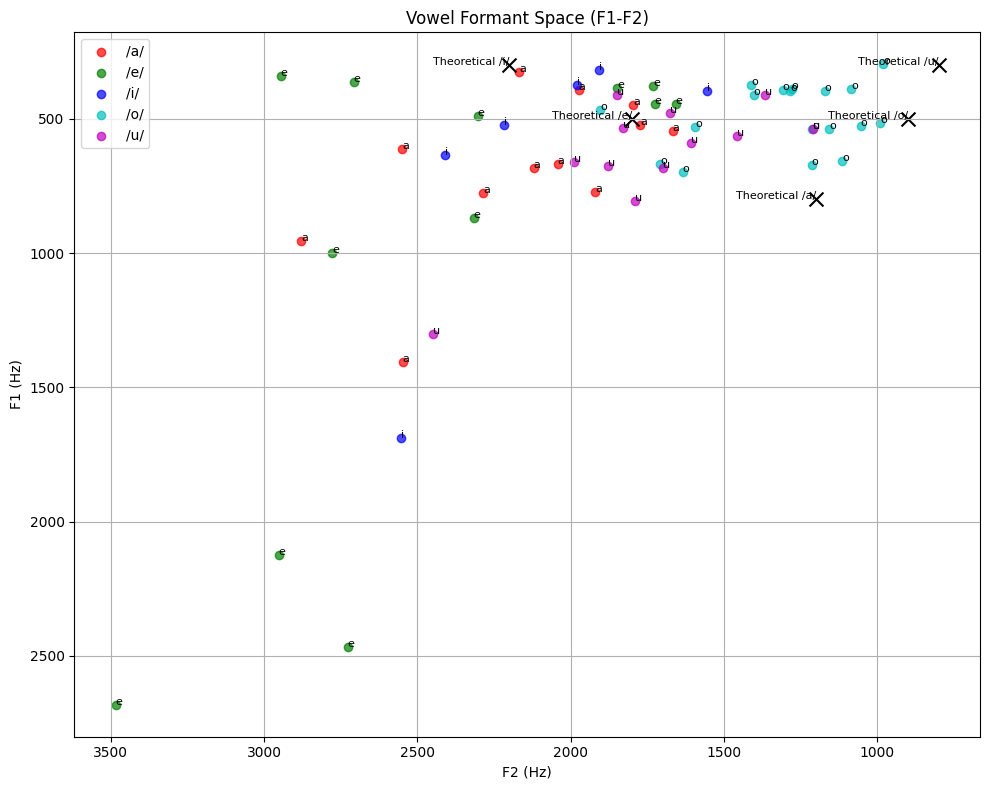

In [29]:
# Visualize formant space
print("\nVisualizing formant space...")
visualize_formant_space(features_df)


Visualizing formant space by category...


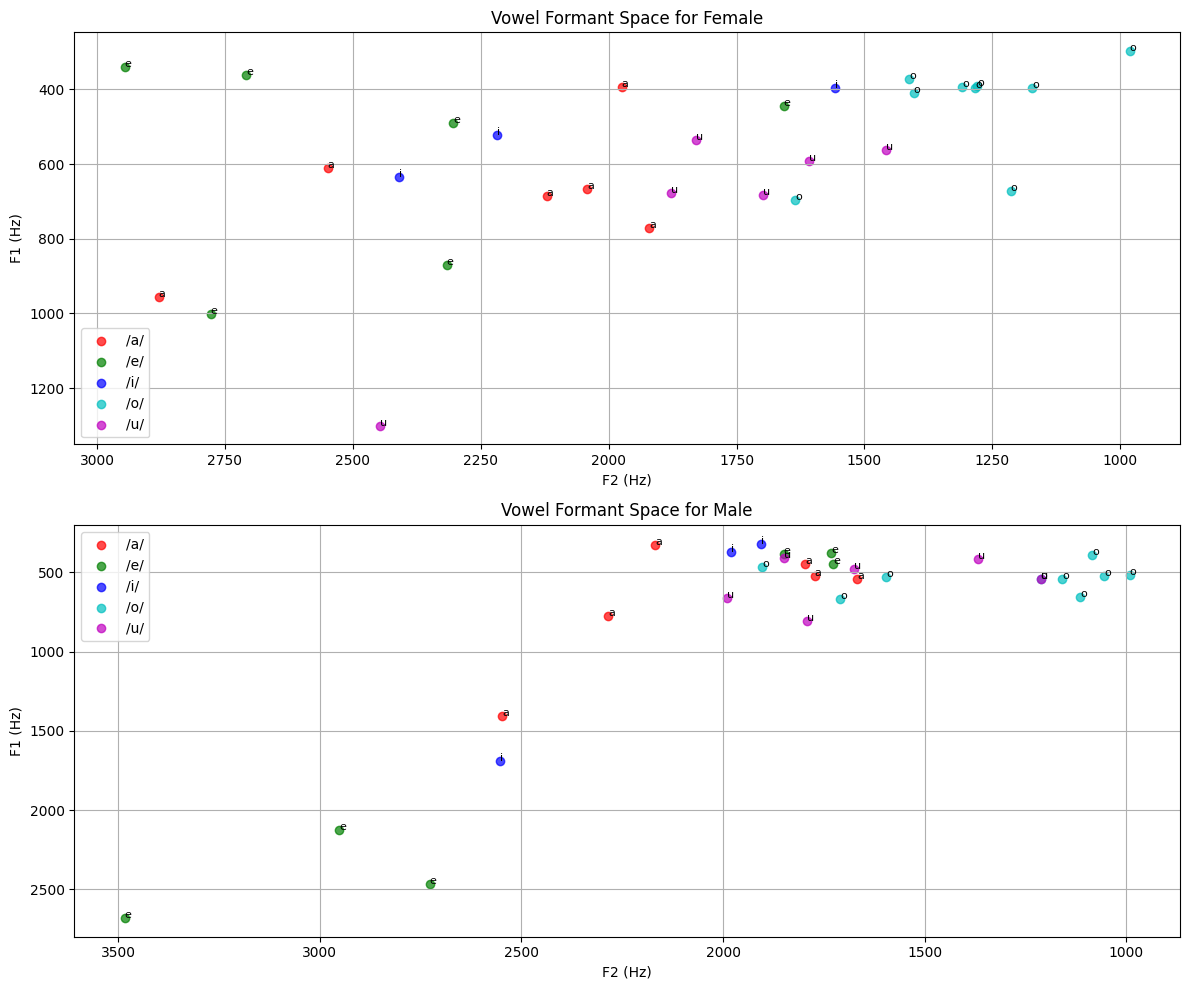

In [33]:
# Visualize formant space by category
print("Visualizing formant space by category...")
visualize_formant_space_by_category(features_df)

Visualizing formant distributions...


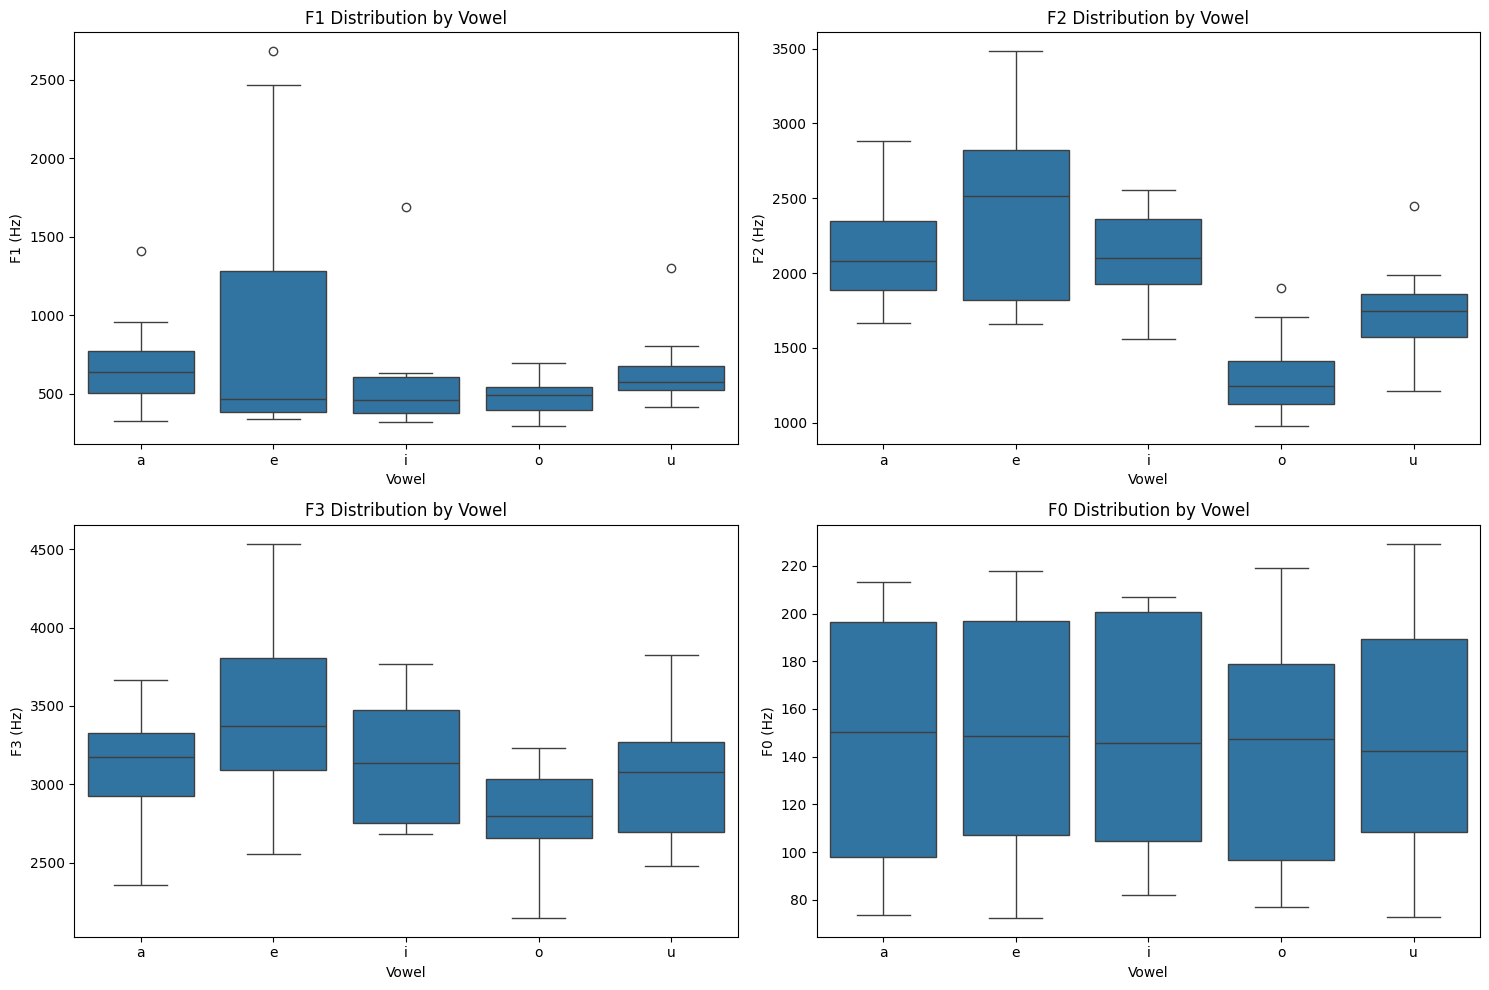

In [34]:
# Visualize formant distributions
print("Visualizing formant distributions...")
visualize_formant_distributions(features_df)

In [35]:
# Prepare features for classification
feature_columns = ['F1_mean', 'F2_mean', 'F3_mean', 'F0_mean', 
                    'F1_std', 'F2_std', 'F3_std', 'F0_std',
                    'F1_F2_ratio', 'F2_F3_ratio']

X = features_df[feature_columns].values
y = features_df['vowel'].values

In [36]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [37]:
# Split into training and testing sets with random_state=45
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=45, stratify=y
)

### KNN Classifier Training and Evaluation

In [39]:
# Train and evaluate KNN classifier
print("\nTraining and evaluating KNN classifier...")
knn_classifier = train_knn_classifier(X_train, y_train, n_neighbors=3)
knn_pred = knn_classifier.predict(X_test)
knn_proba = knn_classifier.predict_proba(X_test)


Training and evaluating KNN classifier...


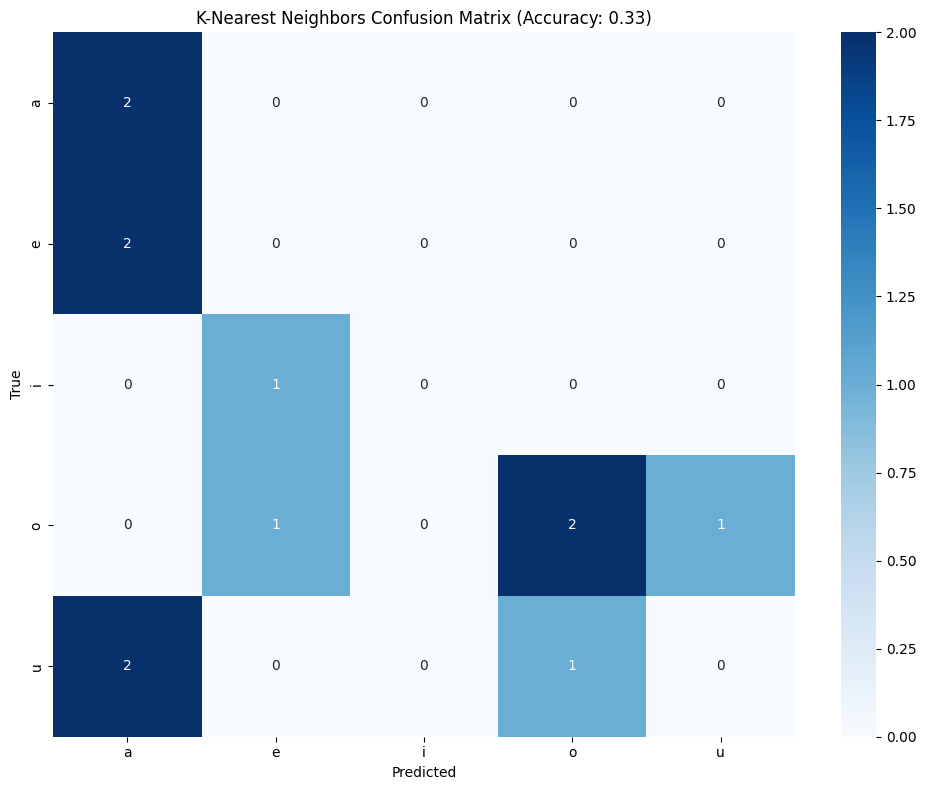

In [41]:
knn_metrics = evaluate_classifier(
    y_test, knn_pred, "K-Nearest Neighbors",
    save_path=os.path.join(OUTPUT_DIR, 'knn_confusion_matrix.png')
)

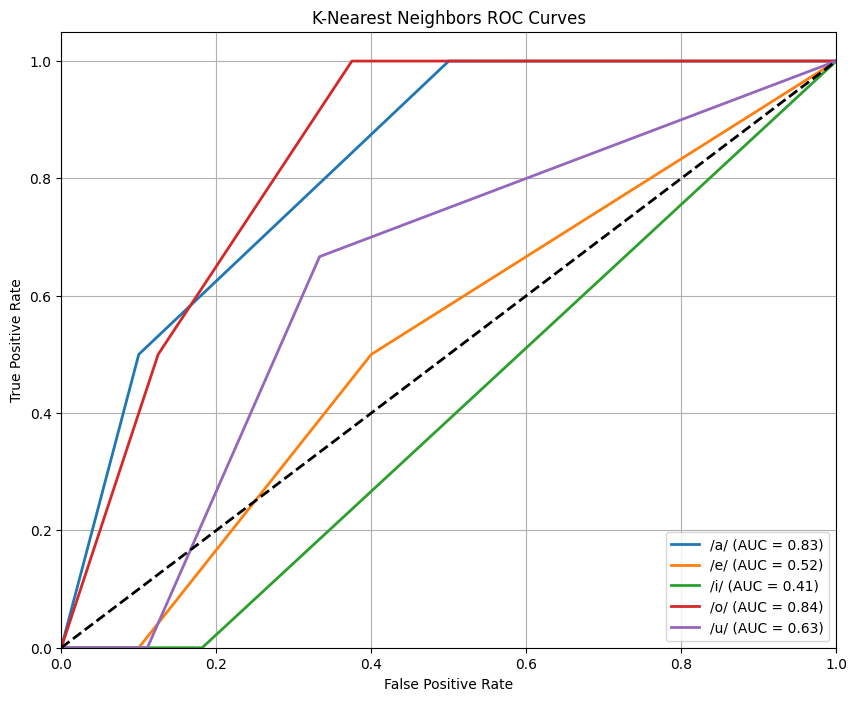

In [43]:
# Plot ROC curves for KNN
plot_roc_curves(
    y_test, knn_proba, knn_classifier.classes_, "K-Nearest Neighbors",
    save_path=os.path.join(OUTPUT_DIR, 'knn_roc_curves.png')
)


### GMM Classifier Training and Evaluation


Training and evaluating GMM classifier...


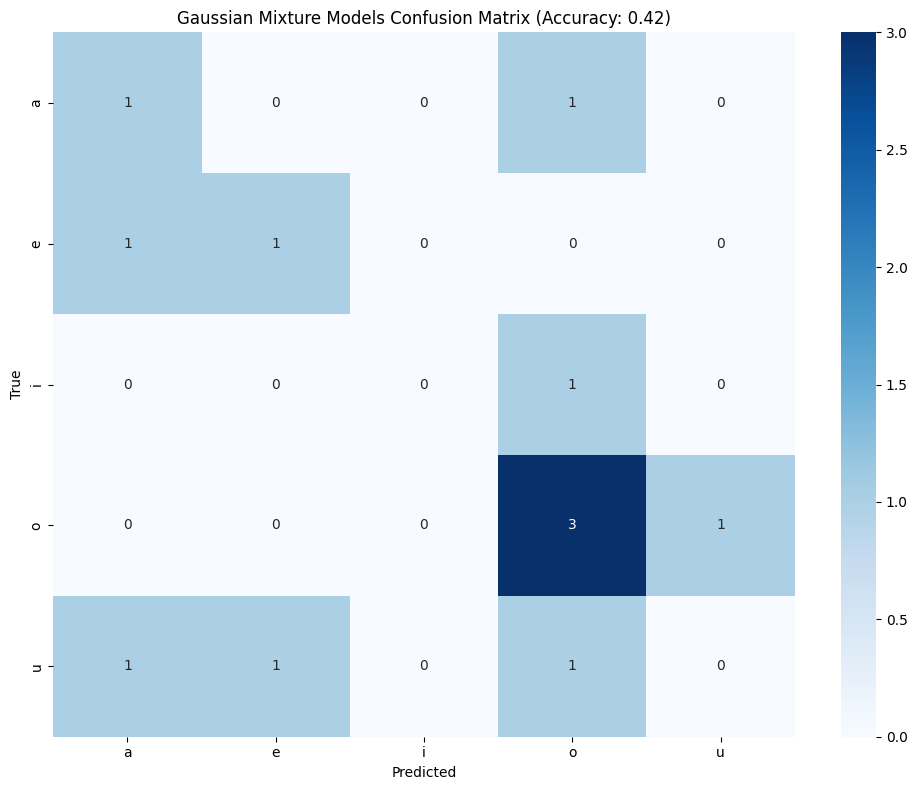

In [45]:
# Train and evaluate GMM classifier
print("\nTraining and evaluating GMM classifier...")
gmm_models = train_gmm_classifier(X_train, y_train, n_components=2)
gmm_pred, gmm_scores = predict_with_gmm(gmm_models, X_test)

gmm_metrics = evaluate_classifier(
    y_test, gmm_pred, "Gaussian Mixture Models",
    save_path=os.path.join(OUTPUT_DIR, 'gmm_confusion_matrix.png')
)

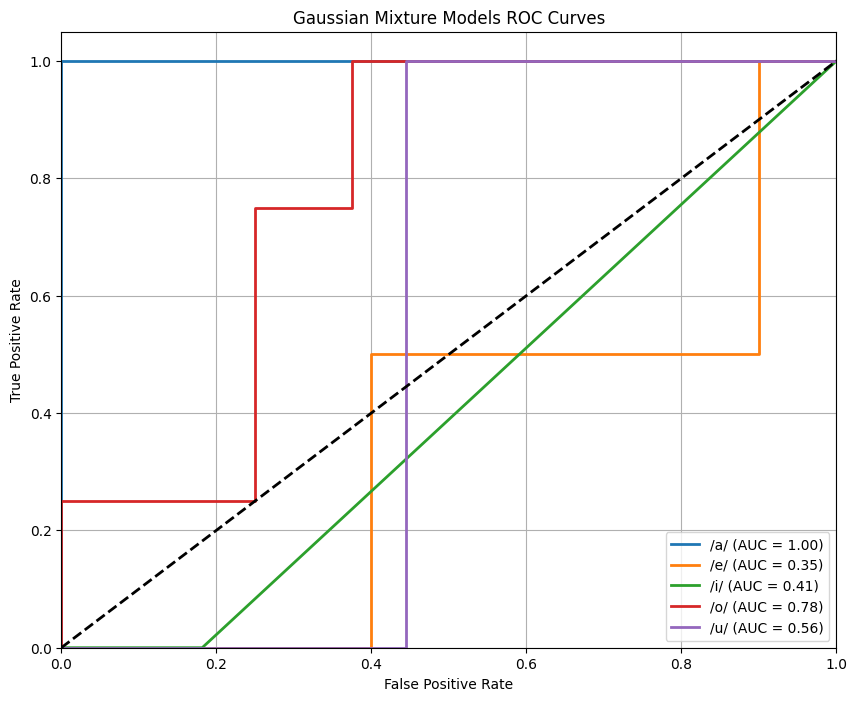

In [46]:
# Normalize GMM scores for ROC curves
gmm_scores_normalized = gmm_scores - np.min(gmm_scores, axis=1, keepdims=True)
gmm_scores_normalized = gmm_scores_normalized / np.sum(gmm_scores_normalized, axis=1, keepdims=True)

# Plot ROC curves for GMM
plot_roc_curves(
    y_test, gmm_scores_normalized, list(gmm_models.keys()), "Gaussian Mixture Models",
    save_path=os.path.join(OUTPUT_DIR, 'gmm_roc_curves.png')
)

### Threshold Classifier


Training and evaluating threshold-based classifier...


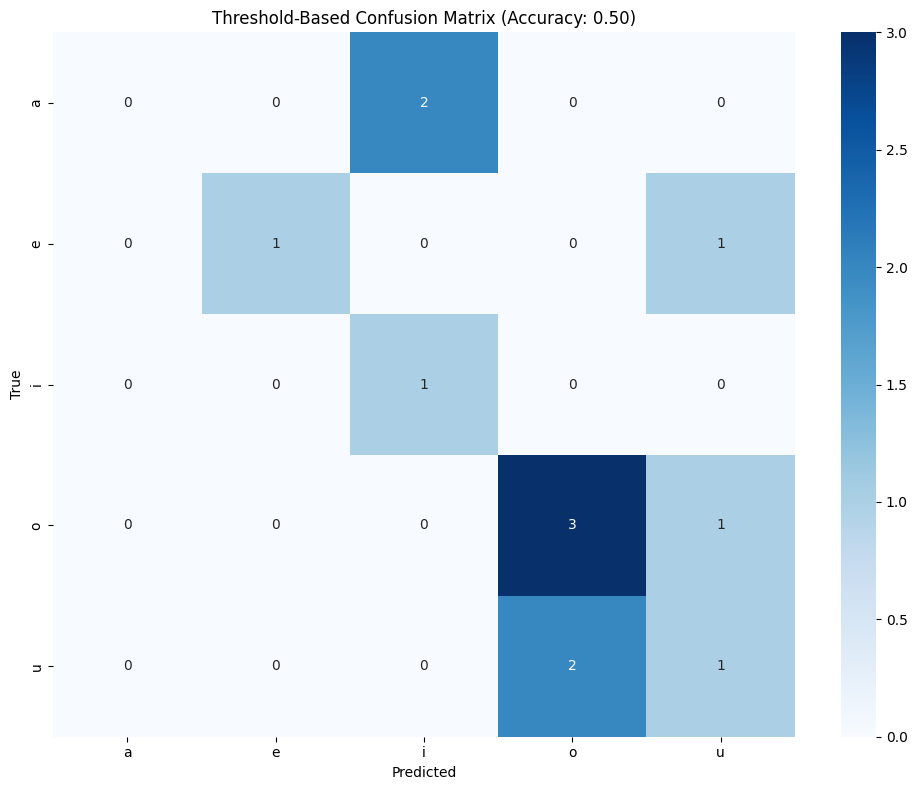

In [50]:
# Train and evaluate threshold-based classifier
print("\nTraining and evaluating threshold-based classifier...")
# Use non-scaled features for threshold classifier
X_train_orig, X_test_orig, _, _ = train_test_split(
    features_df[feature_columns].values, y, test_size=0.2, random_state=45, stratify=y
)

thresholds = train_threshold_classifier(
    pd.DataFrame(X_train_orig, columns=feature_columns).assign(vowel=y_train)
)

threshold_pred, threshold_distances = predict_with_thresholds(
    thresholds, X_test_orig, feature_columns
)

threshold_metrics = evaluate_classifier(
    y_test, threshold_pred, "Threshold-Based",
    save_path=os.path.join(OUTPUT_DIR, 'threshold_confusion_matrix.png')
)


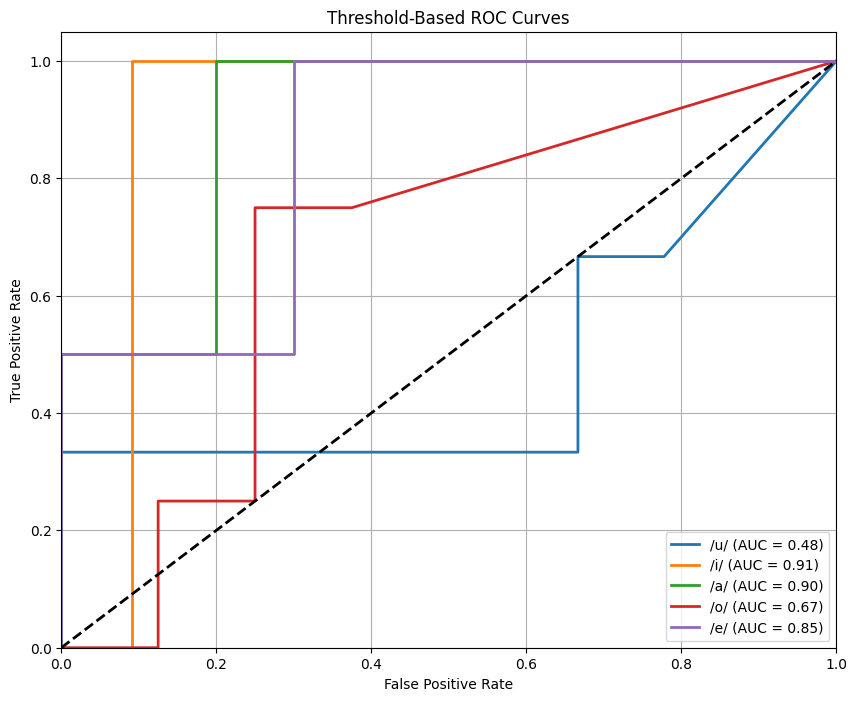

In [51]:

# Normalize threshold distances for ROC curves (invert because smaller distance is better)
threshold_scores = -threshold_distances
threshold_scores_normalized = threshold_scores - np.min(threshold_scores, axis=1, keepdims=True)
threshold_scores_normalized = threshold_scores_normalized / np.sum(threshold_scores_normalized, axis=1, keepdims=True)

# Plot ROC curves for threshold-based classifier
plot_roc_curves(
    y_test, threshold_scores_normalized, list(thresholds.keys()), "Threshold-Based",
    save_path=os.path.join(OUTPUT_DIR, 'threshold_roc_curves.png')
)

#### Compare Classifiers

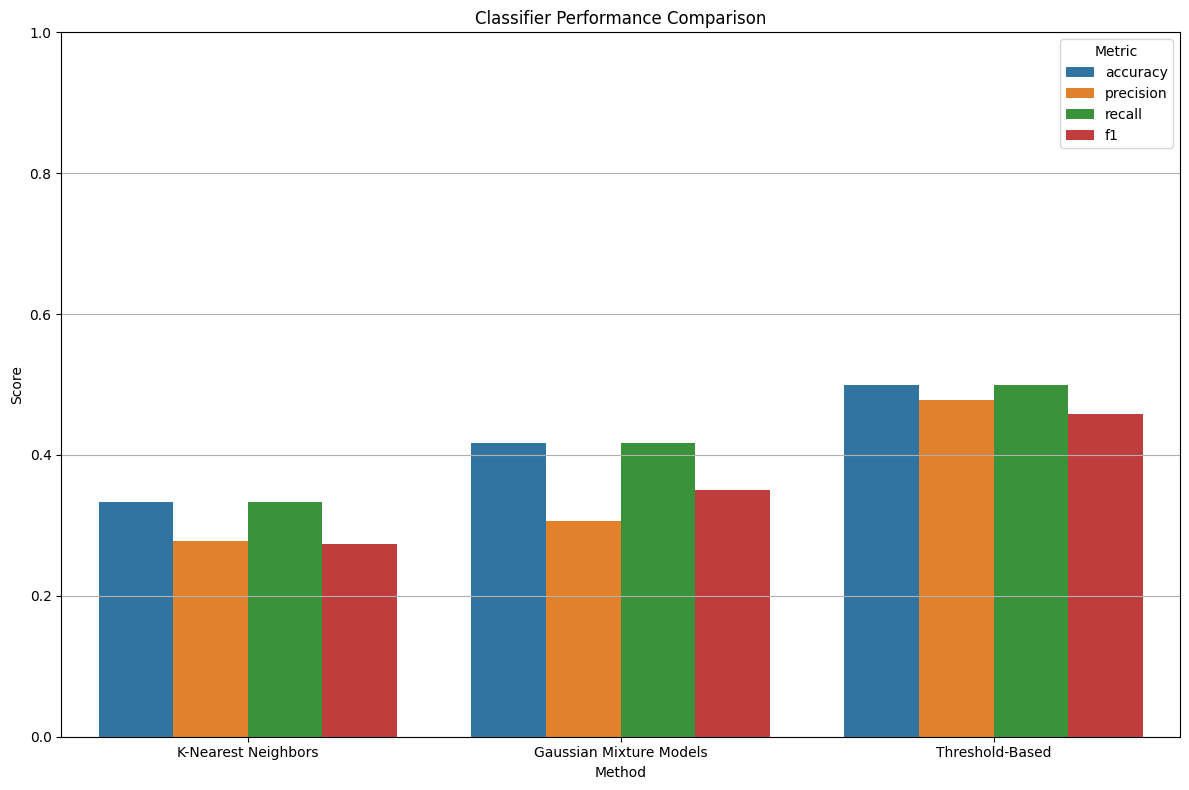

In [55]:
# Compare classifiers
metrics_dict = {
    "K-Nearest Neighbors": knn_metrics,
    "Gaussian Mixture Models": gmm_metrics,
    "Threshold-Based": threshold_metrics
}

compare_classifiers(metrics_dict)

---------------